In [2]:
import pandas as pd
import numpy as np

In [3]:
df_cluster = pd.read_csv('symbols-clusters.csv') 
df_correlation =  pd.read_csv('symbols-correlation-normal.csv ', index_col='Symbol')
symbols = df_correlation.index
n_clusters = len(df_cluster.Cluster.unique())

In [3]:
def create_portfolio_randomly(symbols, n=10):
    selected_symbols =  np.random.choice(symbols, n, replace = False)
    return selected_symbols

In [4]:
def create_portfolio_clusterbased(df_cluster, cluster_num, n = 10 , random_select = True):
    selected_symbols = []
    
    max_cluster = cluster_num
    cls = 1
    if random_select == False:
        cls = np.random.randint(1,5,1)[0]
        max_cluster = 1

    for i in range(n):
        symbol = df_cluster[df_cluster['Cluster'] == cls].sample(1).to_numpy()[0][0]
        selected_symbols.append(symbol)

        if max_cluster == 1:
            continue
            
        if cls < max_cluster:
            cls += 1
        else:
            cls = 1       

    return np.array(selected_symbols)

In [5]:
def calculate_return(tickers , df_correlation, from_date , to_date):
    
    file_temp = 'stocks/{0}.csv'
    
    returns  =  []
    close_price = []
    
    for ticker in tickers:
        
        filename = ('stocks/{0}.csv').format(ticker)
        df = pd.read_csv(filename)     
        df = df.loc[ (df['Date'] >= from_date) & (df['Date'] <= to_date)]        
        ticker_return  =  (df.iloc[-1]['Adj Close'] -  df.iloc[0]['Adj Close'])       
        
        close_price.append(df.iloc[0]['Adj Close'])
        returns.append(ticker_return)
        
    data = {'Symbol': tickers,'Price':close_price,  'Return': returns}
    df_portfolio = pd.DataFrame(data , columns=['Symbol','Price' , 'Return'] )
    df_portfolio = df_portfolio.set_index('Symbol')
    df_portfolio['Weight'] = df_portfolio['Price'].transform(lambda x: x/x.sum())
    
    
    agg = df_portfolio.sum().reindex()
    portfolio_profit = agg['Price'] / agg['Return']
    
    wtg = df_portfolio['Weight'].to_numpy() 
    correlation =  df_correlation.loc[tickers, tickers].to_numpy()
    portfolio_risk = np.dot(wtg, correlation).dot(wtg.T)
    
    
    return df_portfolio , portfolio_profit , portfolio_risk

In [13]:
counter = 50

random_results = []
cluster_results = []

for i in range(counter):
    
    #random_portfolio = create_portfolio_clusterbased(df_cluster, n_clusters , 10 , False)
    random_portfolio = create_portfolio_randomly(symbols, 5) 
    cluster_based_portfolio = create_portfolio_clusterbased(df_cluster , n_clusters , 5 , True)

    _ , random_profit , random_risk = calculate_return(random_portfolio, df_correlation, '2019-10-01','2019-11-30')
    _ , cluster_profit, cluster_risk = calculate_return(cluster_based_portfolio , df_correlation, '2019-10-01','2019-11-30')
    
    random_results.append([random_profit , random_risk])
    cluster_results.append([cluster_profit , cluster_risk])
    
random_results = np.array(random_results)  
cluster_results = np.array(cluster_results)    

In [26]:
columns = ['Cluster_Return','Cluster_Risk','Random_Return','Random_Risk']
data = {'Cluster_Return':cluster_results[:, 0] ,'Cluster_Risk':cluster_results[:, 1],
         'Random_Return':random_results[:, 0],'Random_Risk':random_results[:, 1]}
df_result = pd.DataFrame(data, columns = columns)
df_result.describe()

,Cluster_Return,Cluster_Risk,Random_Return,Random_Risk
count,50.000000,50.000000,50.000000,50.000000
mean,92.980000,1.786200,38.080000,5.231172
std,51.688822,0.913017,47.328138,1.914694
min,-5.000000,0.093100,-49.000000,2.084100
25%,47.250000,1.176250,-1.000000,4.002600
50%,101.500000,1.936250,41.000000,5.098300
75%,136.250000,2.537875,71.750000,6.969650
max,174.000000,3.178700,118.000000,8.367800


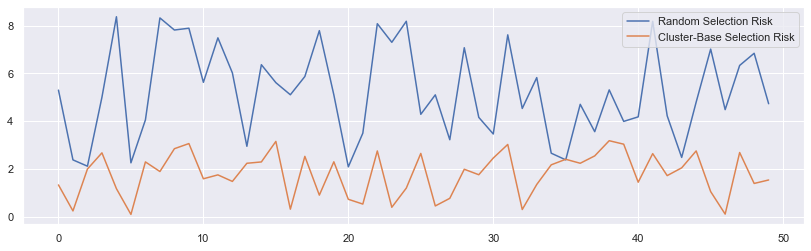

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(14, 4)})
plt.plot(range(counter), random_results[:, 1], label = 'Random Selection Risk')
plt.plot(range(counter), cluster_results[:, 1], label = 'Cluster-Base Selection Risk')

plt.legend()
plt.savefig('fig/random_vs_cluster_portfolio_risk.png', format='png', dpi=400 ,bbox_inches='tight', pad_inches=0)
plt.show()

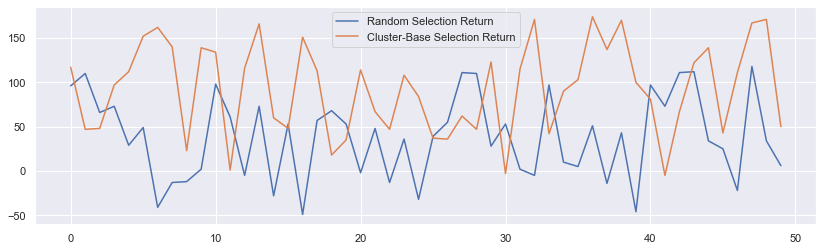

In [24]:
sns.set(rc={'figure.figsize':(14, 4)})
plt.plot(range(counter), random_results[:, 0], label = 'Random Selection Return')
plt.plot(range(counter), cluster_results[:, 0], label = 'Cluster-Base Selection Return')

plt.legend()
plt.savefig('fig/random_vs_cluster_portfolio_return.png', format='png', dpi=400 ,bbox_inches='tight', pad_inches=0)
plt.show()
